# <span style="font-size:36px; color:orange;">Individual assignments ✌🏻</span>

# <span style="font-size:36px; color:orange;">Exploratory Data Analysis and Business Hypothesis Proposal Based on Amazon Headphone Product Data </span>

Scraping keyword: headphones
  Records scraped for 'headphones': 154
Scraping keyword: earbuds
  Records scraped for 'earbuds': 162
Scraping keyword: wireless+headphones
  Records scraped for 'wireless+headphones': 157
Total combined records after removing duplicates: 317


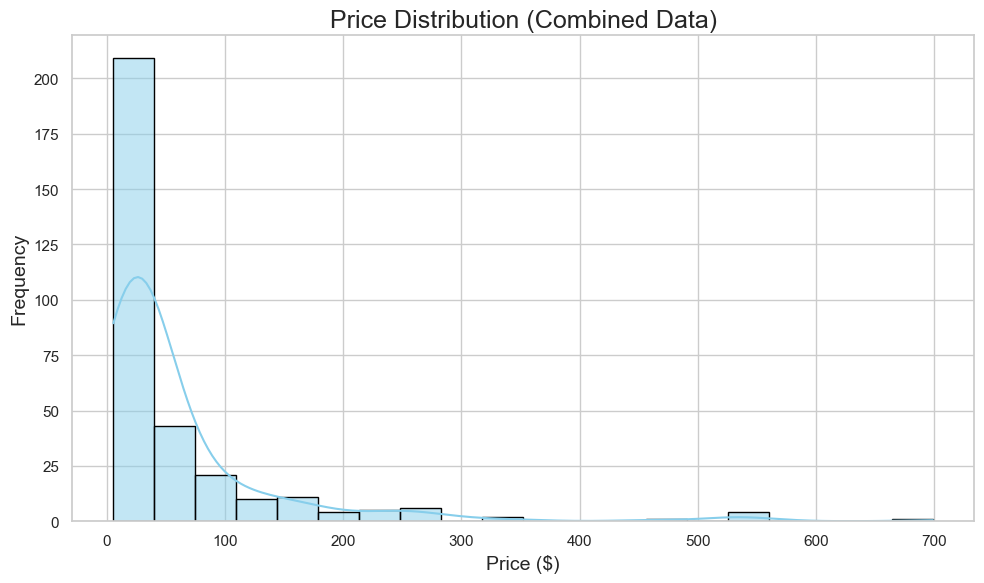

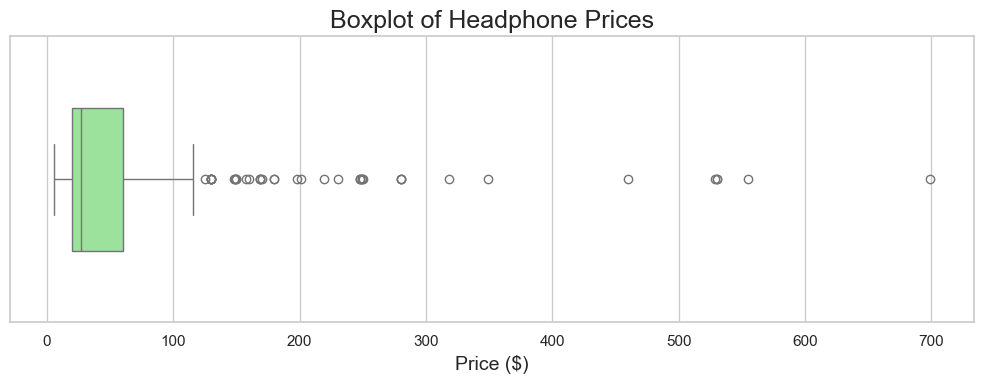

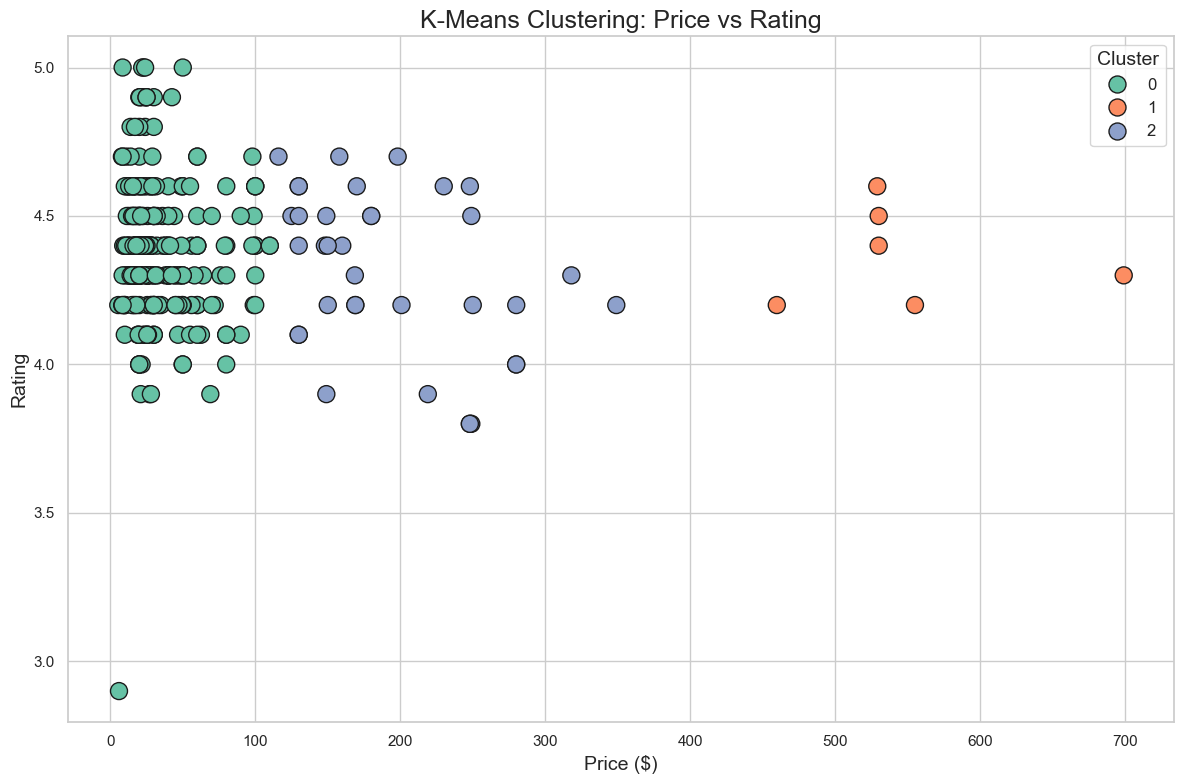

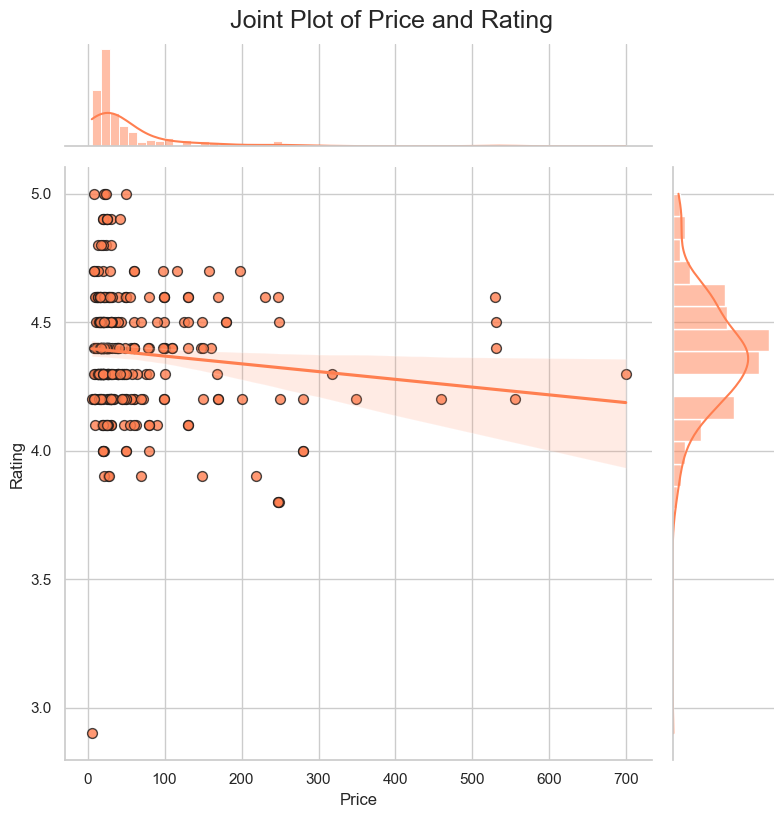

/var/folders/dm/sn7k0w417sx5wmqxcnb4c5fw0000gn/T/ipykernel_95009/1487011468.py:171: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Cluster", y="Rating", data=df, palette="Pastel1", inner="quartile")


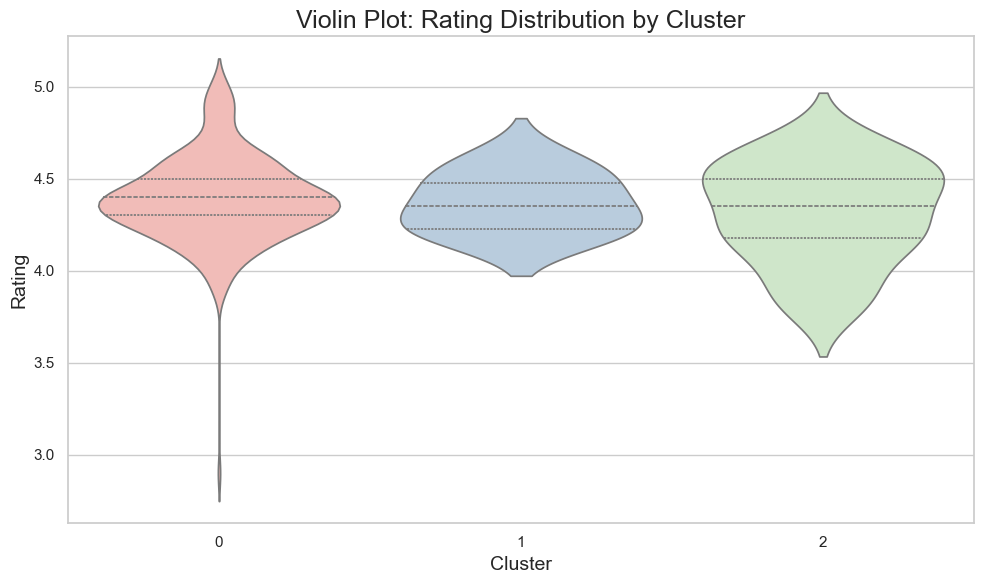

Class distribution:
 HighRating
0    211
1    106
Name: count, dtype: int64

After SMOTE Oversampling:
  Class distribution: HighRating
1    211
0    211
Name: count, dtype: int64
Fitting 5 folds for each of 140 candidates, totalling 700 fits

[Decision Tree] Best Parameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 10}
[Decision Tree] Accuracy:  0.56
[Decision Tree] Precision: 0.58
[Decision Tree] Recall:    0.65
[Decision Tree] F1-Score:  0.62


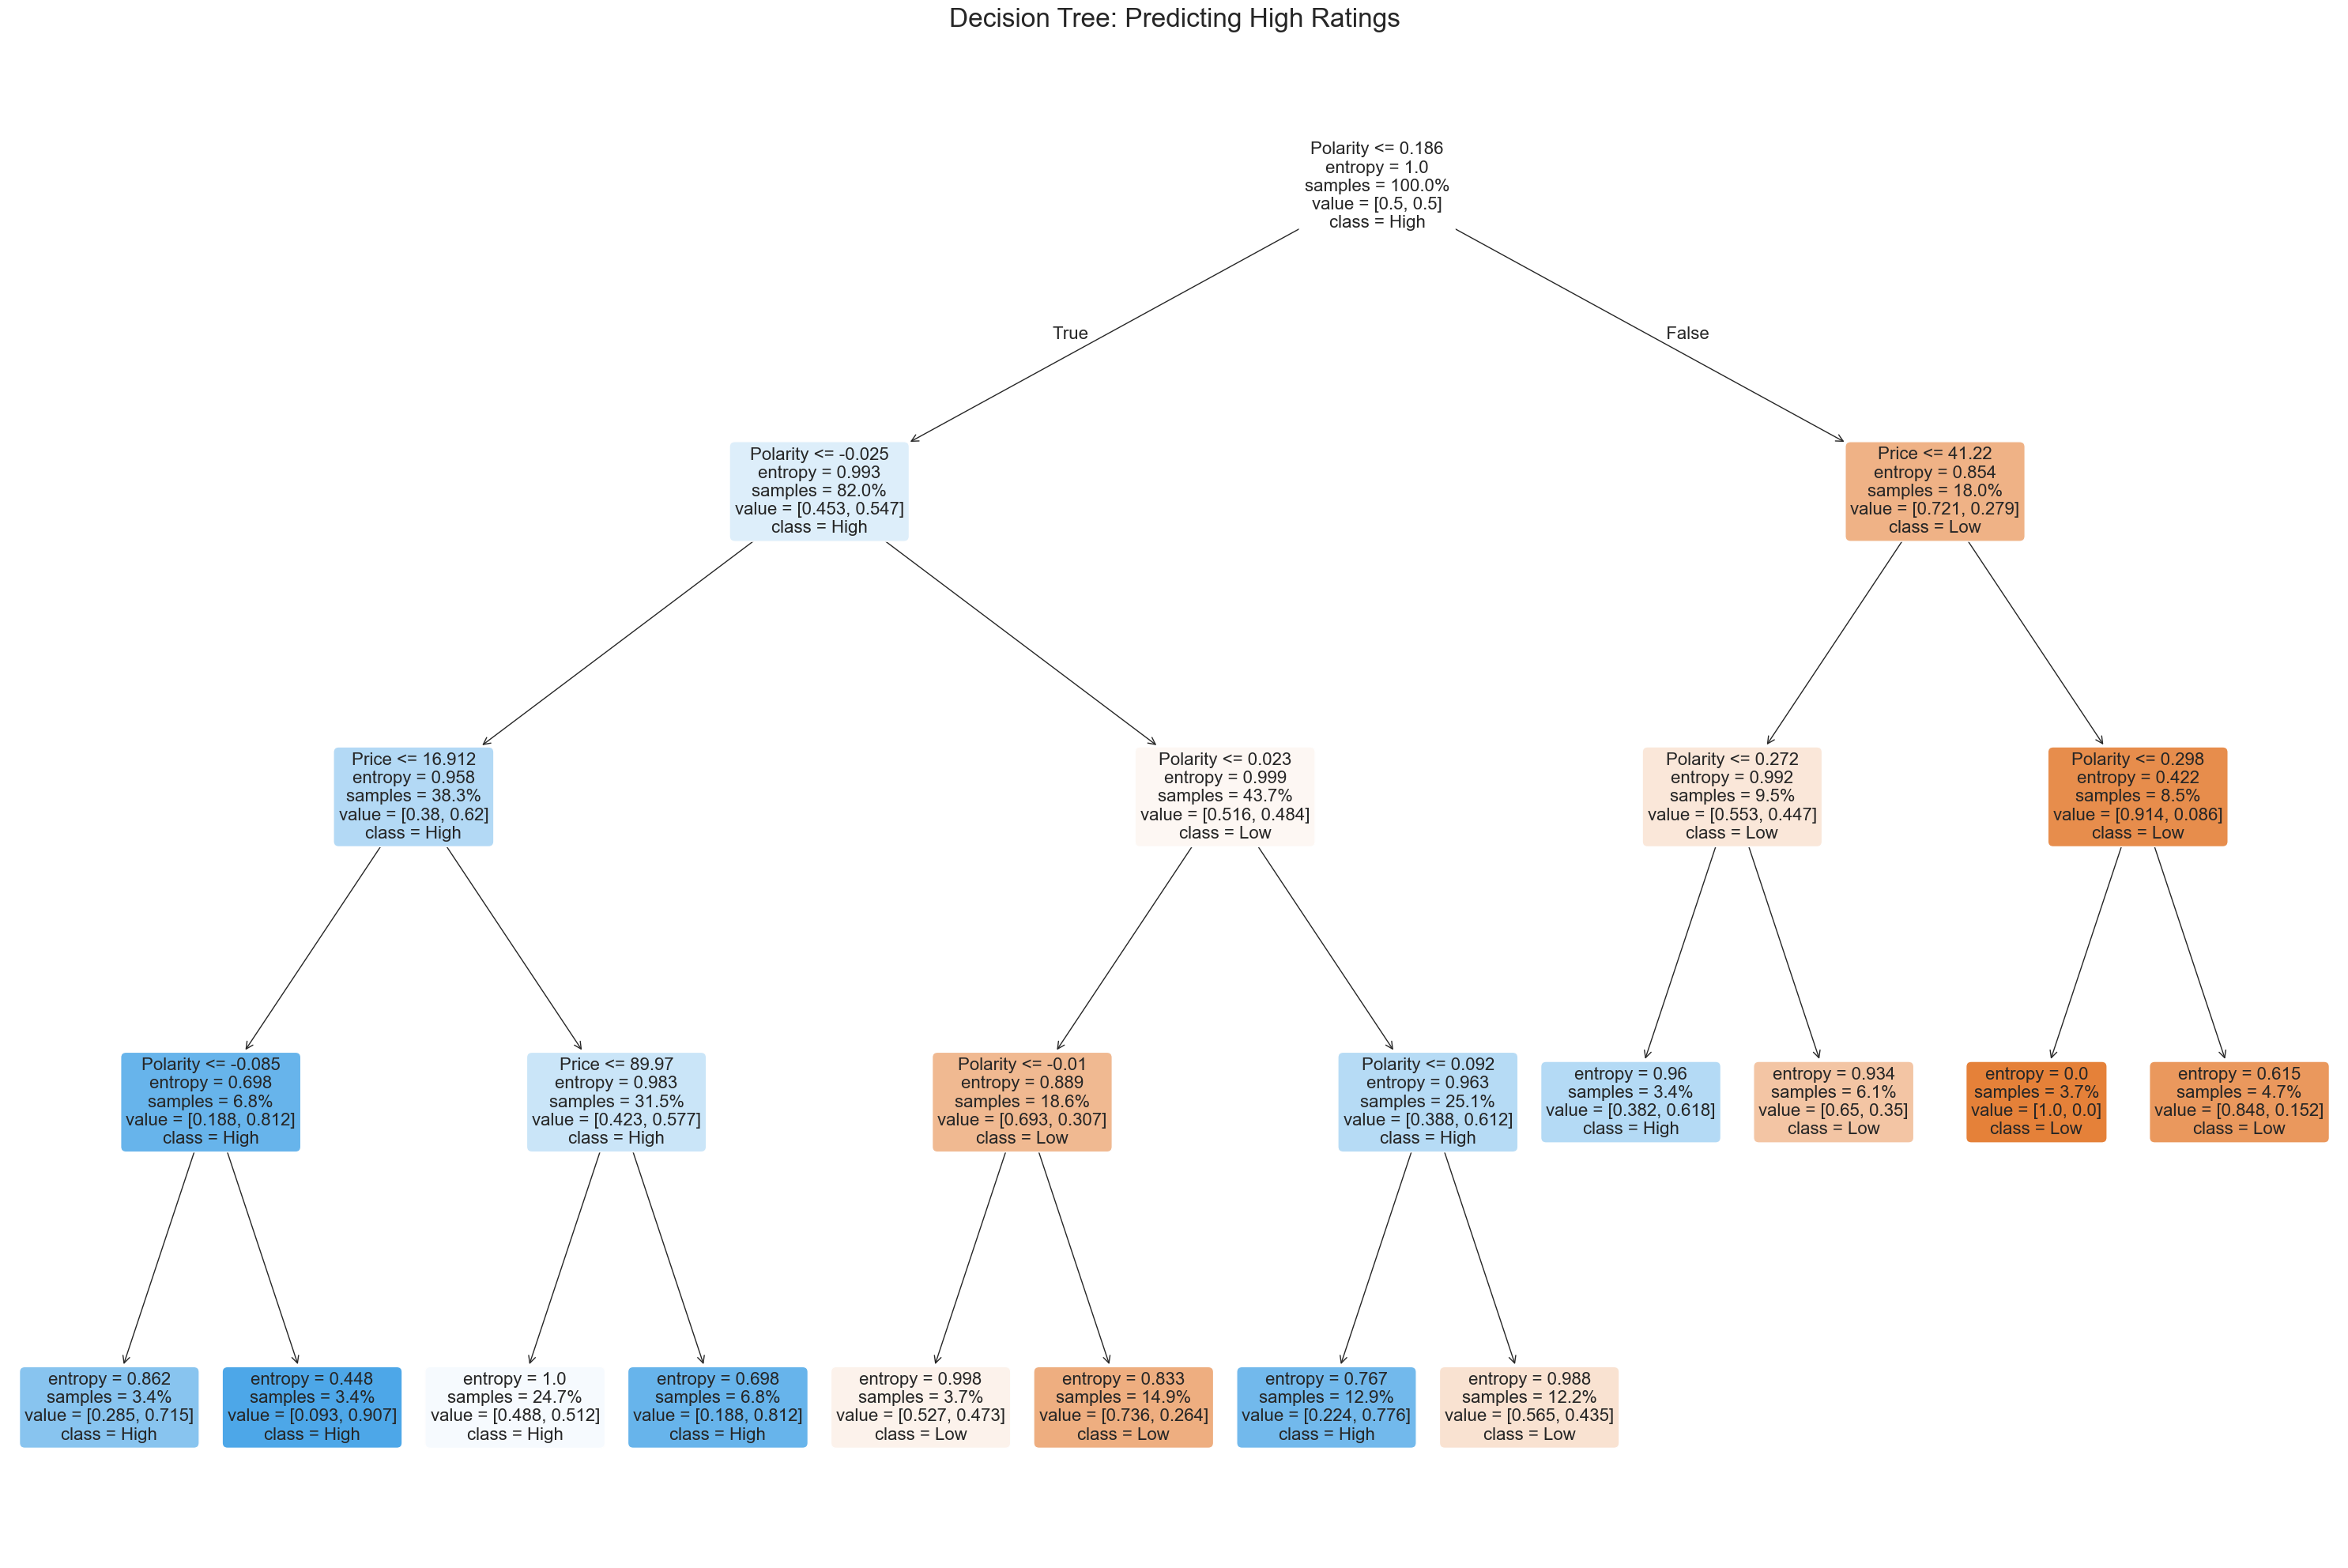

Fitting 5 folds for each of 144 candidates, totalling 720 fits

[Random Forest] Best Parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 2, 'n_estimators': 100}
[Random Forest] Accuracy:  0.55
[Random Forest] Precision: 0.58
[Random Forest] Recall:    0.62
[Random Forest] F1-Score:  0.60


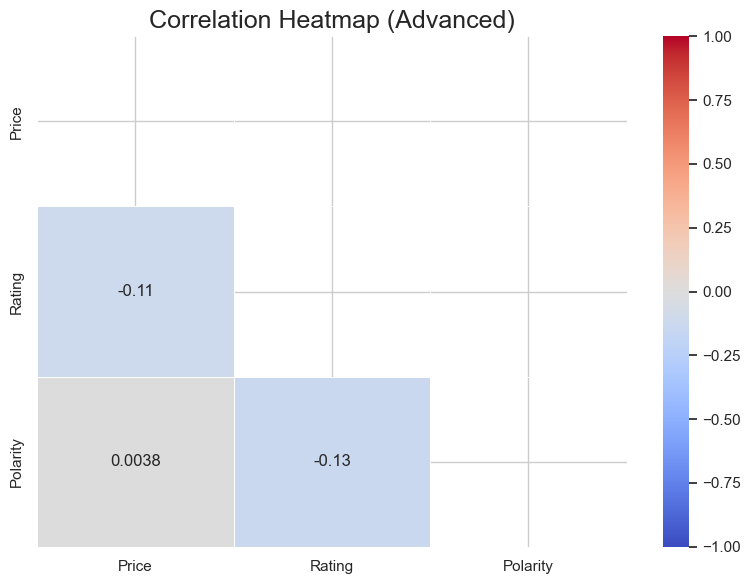

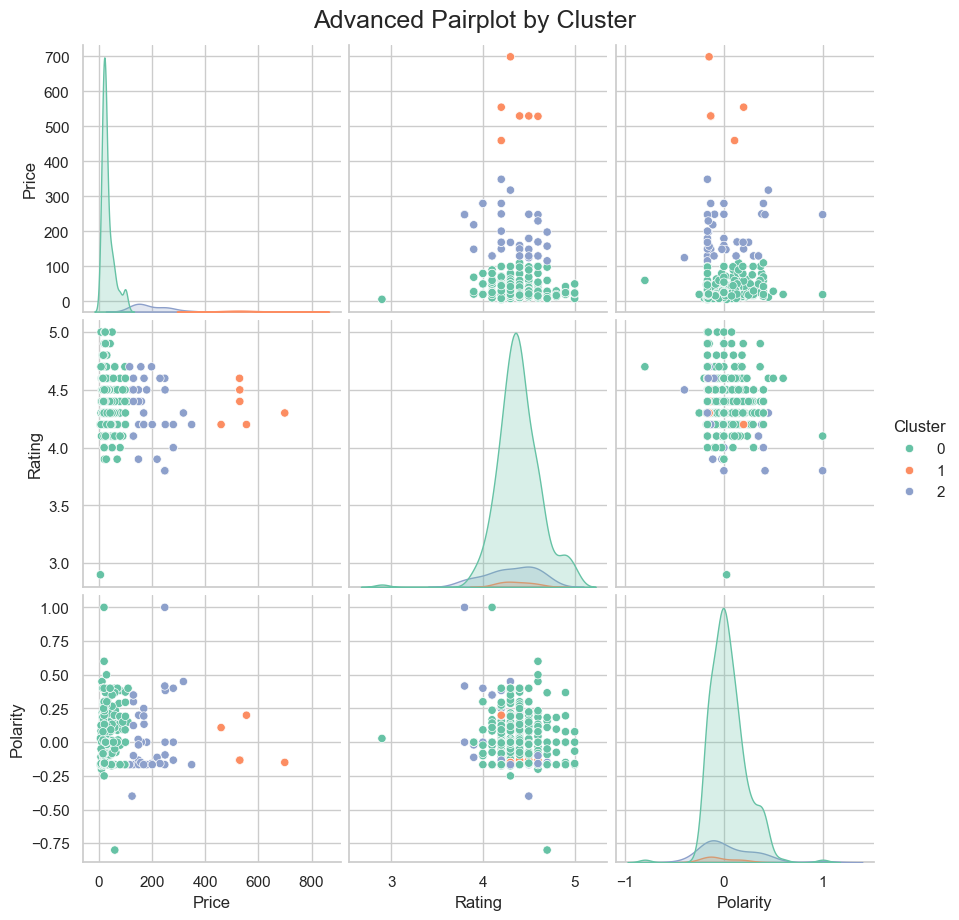

In [10]:
# -----------------------------------------------
# 1. Import Libraries
# -----------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob

# For web scraping
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
import time
import random

# For machine learning
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# For class imbalance handling
# Make sure you have imblearn installed: pip install imblearn
from imblearn.over_sampling import SMOTE

# -----------------------------------------------
# 2. Set Theme for Seaborn
# -----------------------------------------------
sns.set_theme(style="whitegrid")

# -----------------------------------------------
# 3. Define Scraping Function
# -----------------------------------------------
def scrape_amazon(keyword="headphones", max_pages=5):
    """
    Scrapes Amazon search results for a given keyword across multiple pages.
    Returns a pandas DataFrame with columns: Title, Price, Rating, Polarity.
    """
    # Configure headless Chrome
    options = webdriver.ChromeOptions()
    options.add_argument("--headless")
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")

    driver = webdriver.Chrome(
        service=Service(ChromeDriverManager().install()),
        options=options
    )

    products = []

    for page in range(1, max_pages + 1):
        url = f"https://www.amazon.com/s?k={keyword}&page={page}"
        driver.get(url)

        # Random sleep to mimic human browsing and reduce blocking
        time.sleep(random.uniform(2, 5))

        soup = BeautifulSoup(driver.page_source, "html.parser")
        items = soup.select("div.s-main-slot div[data-component-type='s-search-result']")

        for item in items:
            # Extract product title
            title_tag = item.h2
            title = title_tag.text.strip() if title_tag else "N/A"

            # Extract product price
            price_tag = item.select_one("span.a-price > span.a-offscreen")
            try:
                price = float(price_tag.text.replace("$", "").replace(",", "")) if price_tag else None
            except:
                price = None

            # Extract product rating
            rating_tag = item.select_one("span.a-icon-alt")
            try:
                rating = float(rating_tag.text.split()[0]) if rating_tag else None
            except:
                rating = None

            # Calculate sentiment polarity from the title
            polarity = TextBlob(title).sentiment.polarity

            # Only include valid entries
            if price and rating:
                products.append({
                    "Title": title,
                    "Price": price,
                    "Rating": rating,
                    "Polarity": polarity
                })

    driver.quit()
    return pd.DataFrame(products)

# -----------------------------------------------
# 4. Scrape Data from Multiple Keywords
# -----------------------------------------------
df_list = []

# Increase pages/keywords for more data (aim ~1000 records if possible)
keywords = ["headphones", "earbuds", "wireless+headphones"]

for kw in keywords:
    print(f"Scraping keyword: {kw}")
    temp_df = scrape_amazon(keyword=kw, max_pages=10)
    print(f"  Records scraped for '{kw}': {len(temp_df)}")
    df_list.append(temp_df)

# Combine all dataframes
df = pd.concat(df_list, ignore_index=True)

# Remove duplicates based on Title + Price + Rating
df.drop_duplicates(subset=["Title", "Price", "Rating"], inplace=True)

print("Total combined records after removing duplicates:", len(df))

# -----------------------------------------------
# 5. Exploratory Visualizations
# -----------------------------------------------

# 5.1 Histogram of Prices
plt.figure(figsize=(10, 6))
sns.histplot(df['Price'], bins=20, kde=True, color="skyblue", edgecolor="black")
plt.title("Price Distribution (Combined Data)", fontsize=18)
plt.xlabel("Price ($)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.tight_layout()
plt.show()

# 5.2 Boxplot of Prices
plt.figure(figsize=(10, 4))
sns.boxplot(x=df["Price"], color="lightgreen", width=0.5)
plt.title("Boxplot of Headphone Prices", fontsize=18)
plt.xlabel("Price ($)", fontsize=14)
plt.tight_layout()
plt.show()

# 5.3 K-Means Clustering Scatter Plot
df.dropna(subset=["Price","Rating"], inplace=True)

kmeans = KMeans(n_clusters=3, random_state=42)
df["Cluster"] = kmeans.fit_predict(df[["Price", "Rating"]])

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df, x="Price", y="Rating",
    hue="Cluster", palette="Set2", s=150, edgecolor="k"
)
plt.title("K-Means Clustering: Price vs Rating", fontsize=18)
plt.xlabel("Price ($)", fontsize=14)
plt.ylabel("Rating", fontsize=14)
plt.legend(title="Cluster", fontsize=12, title_fontsize=14)
plt.tight_layout()
plt.show()

# 5.4 Joint Plot (Scatter + Marginal Histograms)
sns.jointplot(
    data=df, x="Price", y="Rating",
    kind="reg", height=8, color="coral",
    scatter_kws={'s': 50, 'edgecolor': 'k'}
)
plt.suptitle("Joint Plot of Price and Rating", fontsize=18, y=1.02)
plt.show()

# 5.5 Violin Plot: Rating by Cluster
plt.figure(figsize=(10, 6))
sns.violinplot(x="Cluster", y="Rating", data=df, palette="Pastel1", inner="quartile")
plt.title("Violin Plot: Rating Distribution by Cluster", fontsize=18)
plt.xlabel("Cluster", fontsize=14)
plt.ylabel("Rating", fontsize=14)
plt.tight_layout()
plt.show()

# -----------------------------------------------
# 6. Classification Setup (HighRating)
# -----------------------------------------------
# Create a binary target: HighRating = 1 if Rating >= 4.5, else 0
df["HighRating"] = (df["Rating"] >= 4.5).astype(int)

# Define features and target
X = df[["Price", "Polarity"]]
y = df["HighRating"]

# Check class distribution
print("Class distribution:\n", y.value_counts())

# -----------------------------------------------
# 7. Handle Class Imbalance (SMOTE Oversampling)
# -----------------------------------------------
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

print("\nAfter SMOTE Oversampling:")
print("  Class distribution:", pd.Series(y_res).value_counts())

# -----------------------------------------------
# 8. Train-Test Split
# -----------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.3, random_state=42
)

# -----------------------------------------------
# 9. Approach A: Decision Tree with GridSearchCV
# -----------------------------------------------
dtree_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 3, 4, 5, 6, 7, None],
    'min_samples_leaf': [1, 2, 3, 5, 10],
    'class_weight': [None, 'balanced']
}

dtree = DecisionTreeClassifier(random_state=42)

dtree_grid_search = GridSearchCV(
    estimator=dtree,
    param_grid=dtree_param_grid,
    scoring='f1',  # focusing on F1-score
    cv=5,
    n_jobs=-1,
    verbose=1
)

dtree_grid_search.fit(X_train, y_train)

best_tree = dtree_grid_search.best_estimator_
print("\n[Decision Tree] Best Parameters:", dtree_grid_search.best_params_)

# Predict on test set
y_pred_tree = best_tree.predict(X_test)

# Evaluate
acc_tree = accuracy_score(y_test, y_pred_tree)
prec_tree = precision_score(y_test, y_pred_tree, zero_division=0)
rec_tree = recall_score(y_test, y_pred_tree, zero_division=0)
f1_tree = f1_score(y_test, y_pred_tree, zero_division=0)

print(f"[Decision Tree] Accuracy:  {acc_tree:.2f}")
print(f"[Decision Tree] Precision: {prec_tree:.2f}")
print(f"[Decision Tree] Recall:    {rec_tree:.2f}")
print(f"[Decision Tree] F1-Score:  {f1_tree:.2f}")

# Plot the tuned decision tree with larger font and figure size
plt.figure(figsize=(30, 20))
plot_tree(
    best_tree, 
    feature_names=["Price", "Polarity"], 
    class_names=["Low", "High"],
    filled=True, 
    rounded=True, 
    fontsize=16,
    proportion=True
)
plt.title("Decision Tree: Predicting High Ratings", fontsize=24)
plt.tight_layout()
plt.show()

# -----------------------------------------------
# 10. Approach B: Random Forest with GridSearchCV
# -----------------------------------------------
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, None],
    'min_samples_leaf': [1, 2, 5],
    'class_weight': [None, 'balanced'],
    'criterion': ['gini', 'entropy']
}

rf = RandomForestClassifier(random_state=42)

rf_grid_search = GridSearchCV(
    estimator=rf,
    param_grid=rf_param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)

rf_grid_search.fit(X_train, y_train)

best_rf = rf_grid_search.best_estimator_
print("\n[Random Forest] Best Parameters:", rf_grid_search.best_params_)

# Predict on test set
y_pred_rf = best_rf.predict(X_test)

# Evaluate
acc_rf = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf, zero_division=0)
rec_rf = recall_score(y_test, y_pred_rf, zero_division=0)
f1_rf = f1_score(y_test, y_pred_rf, zero_division=0)

print(f"[Random Forest] Accuracy:  {acc_rf:.2f}")
print(f"[Random Forest] Precision: {prec_rf:.2f}")
print(f"[Random Forest] Recall:    {rec_rf:.2f}")
print(f"[Random Forest] F1-Score:  {f1_rf:.2f}")

# -----------------------------------------------
# 11. Advanced Correlation Heatmap
# -----------------------------------------------
corr = df[["Price", "Rating", "Polarity"]].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(8, 6))
sns.heatmap(corr, mask=mask, annot=True, cmap="coolwarm", linewidths=0.5, vmin=-1, vmax=1)
plt.title("Correlation Heatmap (Advanced)", fontsize=18)
plt.tight_layout()
plt.show()

# -----------------------------------------------
# 12. Pairplot: Visualizing Relationships
# -----------------------------------------------
sns.pairplot(df, vars=["Price", "Rating", "Polarity"], hue="Cluster", palette="Set2", height=3, diag_kind="kde")
plt.suptitle("Advanced Pairplot by Cluster", y=1.02, fontsize=18)
plt.show()


# <span style="font-size:36px; color:orange;">3D K-mean clustering  with standardization and K-Means clustering with standardization ⬇️ </span>

# <span style="font-size:36px; color:orange;">I tested 3D clustering and standardization, both reduced clarity; thus, I retained the original 2D model for better interpretability and practical value.</span>

Scraping keyword: headphones
Records scraped for 'headphones': 158
Scraping keyword: earbuds
Records scraped for 'earbuds': 162
Scraping keyword: wireless+headphones
Records scraped for 'wireless+headphones': 163
Total combined records after removing duplicates: 324


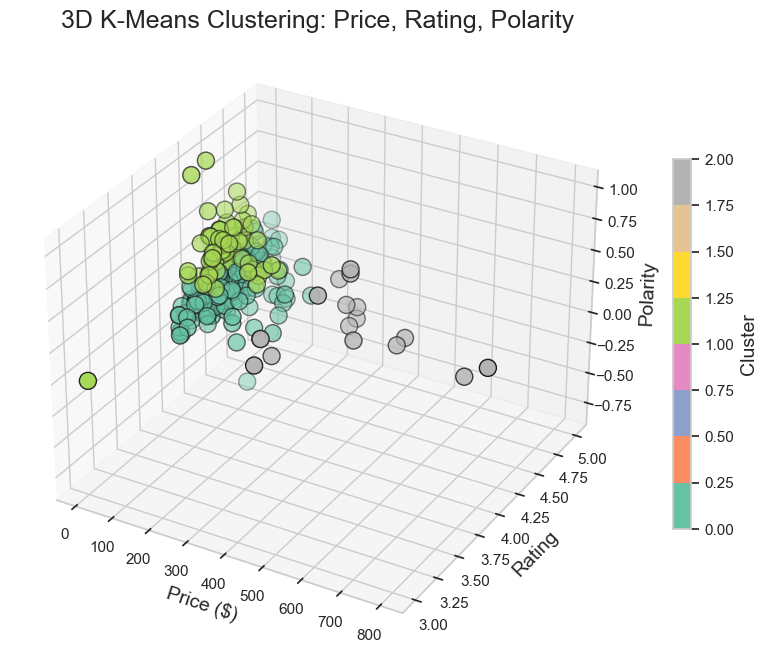

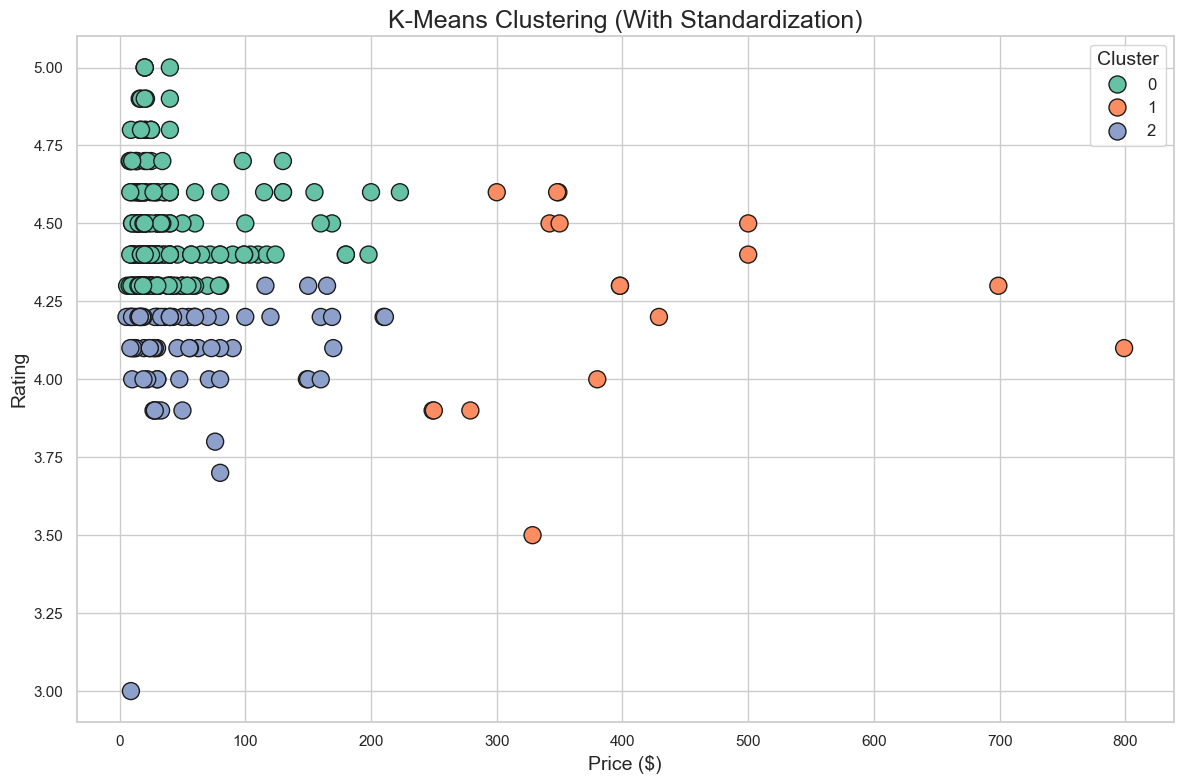

In [14]:
# -----------------------------------------------
# 1. Import Libraries
# -----------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import random
import time

# Selenium and BeautifulSoup for web scraping
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup

# Machine Learning libraries
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Required for 3D plotting
from mpl_toolkits.mplot3d import Axes3D

# Set the Seaborn theme for cleaner visuals
sns.set_theme(style="whitegrid")

# -----------------------------------------------
# 2. Define the Amazon Scraping Function
# -----------------------------------------------
def scrape_amazon(keyword="headphones", max_pages=5):
    """
    Scrapes Amazon search results for a given keyword across multiple pages.
    Returns a pandas DataFrame with columns: Title, Price, Rating, Polarity.
    """
    options = webdriver.ChromeOptions()
    options.add_argument("--headless")
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")

    driver = webdriver.Chrome(
        service=Service(ChromeDriverManager().install()),
        options=options
    )
    
    products = []
    
    # Loop through the defined pages
    for page in range(1, max_pages + 1):
        url = f"https://www.amazon.com/s?k={keyword}&page={page}"
        driver.get(url)
        # Sleep randomly to mimic human behavior
        time.sleep(random.uniform(2, 5))
        
        soup = BeautifulSoup(driver.page_source, "html.parser")
        items = soup.select("div.s-main-slot div[data-component-type='s-search-result']")
        
        for item in items:
            # Extract product title
            title_tag = item.h2
            title = title_tag.text.strip() if title_tag else "N/A"
            
            # Extract product price
            price_tag = item.select_one("span.a-price > span.a-offscreen")
            try:
                price = float(price_tag.text.replace("$", "").replace(",", "")) if price_tag else None
            except Exception:
                price = None
            
            # Extract product rating
            rating_tag = item.select_one("span.a-icon-alt")
            try:
                rating = float(rating_tag.text.split()[0]) if rating_tag else None
            except Exception:
                rating = None
            
            # Calculate sentiment polarity from the title using TextBlob
            polarity = TextBlob(title).sentiment.polarity
            
            # Only include entries with valid Price and Rating values
            if price is not None and rating is not None:
                products.append({
                    "Title": title,
                    "Price": price,
                    "Rating": rating,
                    "Polarity": polarity
                })
                
    driver.quit()
    return pd.DataFrame(products)

# -----------------------------------------------
# 3. Scrape Data from Multiple Keywords
# -----------------------------------------------
keywords = ["headphones", "earbuds", "wireless+headphones"]
df_list = []

for kw in keywords:
    print(f"Scraping keyword: {kw}")
    temp_df = scrape_amazon(keyword=kw, max_pages=10)
    print(f"Records scraped for '{kw}': {len(temp_df)}")
    df_list.append(temp_df)

# Combine data from all keywords and remove duplicate entries
df = pd.concat(df_list, ignore_index=True)
df.drop_duplicates(subset=["Title", "Price", "Rating"], inplace=True)
print("Total combined records after removing duplicates:", len(df))

# -----------------------------------------------
# 4. 3D K-Means Clustering Visualization
# -----------------------------------------------
# Filter out records missing Price, Rating, or Polarity values
df_3d = df.dropna(subset=["Price", "Rating", "Polarity"]).copy()

# Standardize the features to give each equal weight during clustering
features_3d = df_3d[["Price", "Rating", "Polarity"]]
scaler_3d = StandardScaler()
scaled_features_3d = scaler_3d.fit_transform(features_3d)

# Apply K-Means clustering with 3 clusters
kmeans_3d = KMeans(n_clusters=3, random_state=42)
df_3d["Cluster_3D"] = kmeans_3d.fit_predict(scaled_features_3d)

# Create a 3D scatter plot of the clusters
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    df_3d["Price"],
    df_3d["Rating"],
    df_3d["Polarity"],
    c=df_3d["Cluster_3D"],
    cmap="Set2",
    s=150,
    edgecolor="k"
)

ax.set_xlabel("Price ($)", fontsize=14)
ax.set_ylabel("Rating", fontsize=14)
ax.set_zlabel("Polarity", fontsize=14)
ax.set_title("3D K-Means Clustering: Price, Rating, Polarity", fontsize=18)

# Add a colorbar to display cluster numbers
cbar = fig.colorbar(scatter, shrink=0.6)
cbar.set_label("Cluster", fontsize=14)

plt.show()

# -----------------------------------------------
# 5. K-Means Clustering with Standardization (2D)
# -----------------------------------------------
# Remove entries with missing Price or Rating
df_clean = df.dropna(subset=["Price", "Rating"]).copy()

# Standardize the features for Price and Rating
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_clean[["Price", "Rating"]])

# Apply K-Means clustering with 3 clusters on the standardized data
kmeans_std = KMeans(n_clusters=3, random_state=42)
df_clean["Cluster_Std"] = kmeans_std.fit_predict(scaled_features)

# Create a 2D scatter plot using Seaborn for the standardized clustering result
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df_clean, 
    x="Price", 
    y="Rating", 
    hue="Cluster_Std", 
    palette="Set2", 
    s=150, 
    edgecolor="k"
)
plt.title("K-Means Clustering (With Standardization)", fontsize=18)
plt.xlabel("Price ($)", fontsize=14)
plt.ylabel("Rating", fontsize=14)
plt.legend(title="Cluster", fontsize=12, title_fontsize=14)
plt.tight_layout()
plt.show()
